# Analyse Ganomaly output - GAP2 dataset

In [1]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import collections
import pandas as pd
import pandas
import seaborn as sns
import re

from sklearn.metrics import roc_curve, auc, average_precision_score, precision_recall_curve, confusion_matrix, f1_score
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from scipy.stats import shapiro
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from inspect import signature
from datetime import datetime
from pandas.plotting import table 

sns.set()
%matplotlib inline

In [2]:
# instantiate dirs
data_dir = r"C:\Users\TilonSM\Documents\RoadSurfaceDamageUAV\src\models\skipganomaly\output\gan-run_GAP2"
directories = os.listdir(data_dir)
directories = [i for i in directories if os.path.isdir(os.path.join(data_dir, i)) if i != 'report']

# extract and sort integer experiment numbers
experiments = [int(re.findall(r'\d+', s)[0]) for s in directories]
experiments.sort()

experiments = ['exp'+ str(i) for i in experiments]

In [3]:
experiments

['exp60', 'exp60']

### Define functions

In [2]:
def D_G_loss(d, g, x, show=False):
    # plot Discriminator and Generator error
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
    ax[0].plot(x, d, 'g')
    ax[1].plot(x, g, 'b')
    ax[0].grid(True)
    ax[1].grid(True)
    ax[0].set_xlabel('Iterations')
    ax[1].set_xlabel('Iterations')
    ax[0].set_ylabel('Error')
    ax[1].set_ylabel('Error')
    ax[0].set_title('Discriminator error')
    ax[1].set_title('Generator error')
    for i in indexes:
        ax[0].axvline(i[1] * 8000, linestyle='--', color='k')
        ax[0].text(i[1] * 8000 + 100, max(d)-0.1 , "epoch {}".format(i[0]))
        ax[1].axvline(i[1] * 8000, linestyle='--', color='k')
        ax[1].text(i[1] * 8000 + 100, max(g)-0.1 , "epoch {}".format(i[0]))
    plt.subplots_adjust(hspace=0.4)
    fig.savefig(os.path.join(report_dir, "D_G_loss.jpg"), dpi=600, bbox_inches='tight')
    plt.close(fig)

In [3]:
def adv_con_enc_error(adv, con, lat, x, show=False):

    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20,15))
    ax[0].plot(x, adv, 'g')
    ax[1].plot(x, con, 'b')
    ax[2].plot(x, lat, 'm')
    ax[0].grid(True)
    ax[1].grid(True)
    ax[2].grid(True)
    ax[0].set_xlabel('Iterations')
    ax[1].set_xlabel('Iterations')
    ax[2].set_xlabel('Iterations')
    ax[0].set_ylabel('Error')
    ax[1].set_ylabel('Error')
    ax[2].set_ylabel('Error')
    ax[0].set_title('Adversarial loss')
    ax[1].set_title('Contextual loss')
    ax[2].set_title('Lateral loss')
    for i in indexes:
        ax[0].axvline(i[1] * 8000, linestyle='--', color='k')
        ax[0].text(i[1] * 8000 + 10, max(adv) , "epoch {}".format(i[0]))
        ax[1].axvline(i[1] * 8000, linestyle='--', color='k')
        ax[1].text(i[1] * 8000 + 10, max(con) , "epoch {}".format(i[0]))
        ax[2].axvline(i[1] * 8000, linestyle='--', color='k')
        ax[2].text(i[1] * 8000 + 10, max(lat) , "epoch {}".format(i[0]))
    plt.subplots_adjust(hspace=0.4)
    fig.savefig(os.path.join(report_dir, "adv_con_lat_loss.jpg"), dpi=600, bbox_inches='tight')
    plt.close(fig)

In [4]:
def AUC(epoch, AUC_epoch, show=False):
    plt.figure()
    plt.plot(epoch, auc_epoch)
    plt.grid(True)
    plt.xlabel("epoch")
    plt.ylabel("score")
    plt.title("Area Under the Receiver Operator Curve")
    plt.savefig(os.path.join(report_dir, "AUC_epoch.jpg"), dpi=600, bbox_inches='tight')
    plt.close()

In [5]:
def normaltest(data):
    stat, p = shapiro(data)

    alpha = 0.05
    if p > alpha:
#         print('Sample looks Gaussian (fail to reject H0)')
        message = "Gaussian"
    else:
#         print('Sample does not look Gaussian (reject H0)')
        message = "Non-Gaussian"

    return message

In [6]:
def get_threshold(normal, abnormal):
    # Find natural cut of point between two distributions
    # https://stackoverflow.com/questions/22579434/python-finding-the-intersection-point-of-two-gaussian-curves

    m1 = np.mean(normal)
    std1 = np.std(normal)
    m2 = np.mean(abnormal)
    std2 = np.std(abnormal)
    
    a = 1/(2*std1**2) - 1/(2*std2**2)
    b = m2/(std2**2) - m1/(std1**2)
    c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log(std2/std1)
    
    return np.roots([a,b,c])


In [7]:
def anomaly_dist(normal, abnormal, message1, message2, epoch, show=False):
    plt.hist(an_scores_normal, bins=50, color='b', label='Normal - {}'.format(normal_message))
    plt.hist(an_scores_abnormal, bins=50, color='g', label = 'Abnormal - {}'.format(anom_message))
    plt.title('Anomaly scores distribution - epoch {}'.format(epoch))
    plt.grid(True)
    plt.ylabel('Frequency')
    plt.xlabel('Anomaly score')
    plt.axvline(threshold, color='r')
    plt.text(threshold + 0.05, 7750 , "Threshold {}".format(round(threshold, 4)), color='r')
    plt.legend()
    plt.savefig(os.path.join(report_dir, "anomaly_scores_distribution.jpg"), dpi=600, bbox_inches='tight')
    plt.close()

In [8]:
def ROC_curve(actual, predicted, epoch, show=False):
    # ROC curve
    fpr, tpr, thresholds = roc_curve(actual, predicted)
    roc_auc = auc(fpr, tpr)

    # Equal Error Rate
    eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)

    # line weight
    lw = 2
    
    # plot images
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='(AUC = %0.2f)' % (roc_auc))
#     plt.plot([0, 1], [1, 0], color='navy', lw=1, linestyle=':')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.title('Highest AUC - epoch {}'.format(round(epoch)))
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(report_dir, "ROC_curve.jpg"), dpi=600, bbox_inches='tight')
    plt.close()

In [9]:
def pr_curve(actual, predicted, show=False):
    precision, recall, _ = precision_recall_curve(actual, predicted)
    step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: AP={}\n Threshold {}'.format(round(ap, 2), round(threshold,3)))
    plt.savefig(os.path.join(report_dir, "PR_curve.jpg"), dpi=600, bbox_inches='tight')
    plt.close()

In [10]:
def save_high_score(highscore):
    path = r"C:\Users\TilonSM\Documents\RoadSurfaceDamageUAV\data\processed\buildings\test"
    file = highscore[0]
    if 'abnormal_' in file:
        directory = '1.abnormal'
    elif 'normal_' in file:
        directory = '0.normal'
    
    filepath = os.path.join(os.path.join(path, directory), file)
    
    img = plt.imread(filepath, format='jpeg')
    plt.imshow(img)
    plt.title("{} - correctly classified {} times".format(file, highscore[1]))
    plt.grid(False)
    plt.savefig(os.path.join(report_dir, "real_vs_fake"), dpi=600, bbox_inches='tight')
    plt.close()

In [11]:
def plot_confusion_matrix(y_true, y_pred, threshold, classes=None, dummy=False, cmap=plt.cm.Blues, show=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    titles = ['Confusion matrix, without normalization', "Normalized confusion matrix"]
    # Compute normalized matrix
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    tn, fp, fn, tp = cm.ravel()
    
    Recall = tp / (tp + fn)
    Precision = tp / (tp + fp)
    Accuracy = (tp + tn) / (tp + fn + fp + tn)
    F1_score = 2 * ((Precision * Recall) / (Precision + Recall))
    metric_text = "Recall {}, Precision {}, Accuracy {}, F1_score {}, Threshold value {}".format(round(Recall,3), 
                                                                                                round(Precision,3),
                                                                                                round(Accuracy, 3),
                                                                                                round(F1_score, 3),
                                                                                                round(threshold, 3))
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    
    csfont = {'fontname':'Comic Sans MS'}

    for i, c in enumerate([cm, cm_norm]):
        im = ax[i].imshow(c, interpolation='nearest', cmap=cmap)
        ax[i].set(xticks=np.arange(c.shape[1]),
               yticks=np.arange(c.shape[0]),
               xticklabels=classes, yticklabels=classes,
               title=titles[i],
               ylabel='True label',
               xlabel='Predicted label')
        # Rotate the tick labels and set their alignment.
        plt.setp(ax[i].get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")
        ax[i].grid(False)
        
        divider = make_axes_locatable(ax[i])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        # Loop over data dimensions and create text annotations.
        fmt = '.3f' if i == 1 else 'd'
        thresh = c.max() / 2.
        for k in range(c.shape[0]):
            for j in range(c.shape[1]):
                ax[i].text(j, k, format(c[k, j], fmt),
                        ha="center", va="center", fontsize=12,
                        color="white" if c[k, j] > thresh else "black")
    fig.tight_layout()
    ax[2].patch.set_visible(False)
    ax[2].xaxis.set_visible(False)  # hide the x axis
    ax[2].yaxis.set_visible(False)  # hide the y axis
    ax[2].axis('off')
    ax[2].grid(False)
    table1 = ax[2].table(cellText=[[round(Recall,3)],[round(Precision,3)],[round(Accuracy,3)],[round(F1_score,3)],
                                   [round(threshold,3)]],
          rowLabels = ['Recall', 'Precision', 'Accuracy', 'F1_score', 'Threshold'],
          colLabels= ['Metrics'],
              loc='center', bbox=[0.2,0.2,0.3,0.6])
    table1.set_fontsize(14)
    if dummy:
        fig.suptitle("Dummy clasifier statistics")
        plt.savefig(os.path.join(report_dir, "{}_cm_metrics.jpg".format("DUMMY")), dpi=600, bbox_inches='tight')
    else:
        plt.savefig(os.path.join(report_dir, "cm_metrics.jpg"), dpi=600, bbox_inches='tight')
    
    if show:
        plt.show()
        
    plt.close(fig)
    
    return Recall, Precision, Accuracy, F1_score

In [12]:
def fake_vs_real(exp_dir, report_dir, show=False):
    test_dir = os.path.join(exp_dir, 'test')
    testimg_dir = os.path.join(test_dir, 'images')
    
    nr_files = len(os.listdir(testimg_dir))
    samplenr = (nr_files/2) / 2
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))
    real = plt.imread(os.path.join(testimg_dir, "real_{}.jpg".format(int(samplenr))), format='jpeg')
    fake = plt.imread(os.path.join(testimg_dir, "fake_{}.jpg".format(int(samplenr))), format='jpeg')
    ax[0].imshow(real)
    ax[0].set_title("Real")
    ax[0].grid(False)
    ax[1].imshow(fake)
    ax[1].set_title('Fake')
    ax[1].grid(False)
    fig.savefig(os.path.join(report_dir, "real_vs_fake"), dpi=600, bbox_inches='tight')
    plt.close(fig)

In [15]:
# RECALL = []
# PRECISION = []
# ACCURACY = []
# F1_SCORE = []
# AUC_all = []

for i in range(50, 109):
    
    exp="exp" + str(i)
    print(exp)
    exp_dir = os.path.join(data_dir, exp)
    report_dir = os.path.join(exp_dir, "report")

    if not os.path.exists(report_dir):
        os.mkdir(report_dir)

    # specify training and training/eror dir
    train_dir = os.path.join(exp_dir, "train")
    error_dir = os.path.join(train_dir, "errors")

    # open eror pkl file
    errors = []
    with (open(os.path.join(error_dir, "errors.pkl"), "rb")) as openfile:
        while True:
            try:
                errors.append(pickle.load(openfile))
            except EOFError:
                break

    # store error information
    epoch = []
    steps = []
    err_d = []
    err_g = []
    err_g_adv = []
    err_g_con = []
    err_g_lat = []

    for i in errors:
        epoch.append(i['epoch'])
        steps.append(i['steps'])
        err_d.append(i['errors']['err_d'])
        err_g.append(i['errors']['err_g'])
        err_g_adv.append(i['errors']['err_g_adv'])
        err_g_con.append(i['errors']['err_g_con'])
        err_g_lat.append(i['errors']['err_g_lat'])

    # count number of unique epochs
    unique_epoch = list(set(epoch))
    # find index of unique epochs
    indexes = [(x, epoch.index(x)) for x in unique_epoch]

    ### 1. Generator and Discriminator error
    # create x value list for plotting purposes
    x = np.arange(min(steps), (len(err_d)) * 8000, 8000)

    D_G_loss(err_d, err_g, x)

    ### 2. Adversarial, contextual and encoder error

    # plot adv, cont and enc error
    adv_con_enc_error(err_g_adv, err_g_con, err_g_lat, x)

    # Testing

    #### Remind ourselves of test set statistics

    # test statistics
    test_norm = r"C:\Users\TilonSM\Documents\RoadSurfaceDamageUAV\data\processed\GAP2\test_norm\test_norm.npy"
    test_anom = r"C:\Users\TilonSM\Documents\RoadSurfaceDamageUAV\data\processed\GAP2\test_anom\test_anom.npy"
    t1 = np.load(test_norm, mmap_mode="r")
    t2 = np.load(test_anom, mmap_mode='r')
    test_len = len(t1) + len(t2)

#     print("normal samples {}".format(len(t1)))
#     print("abnormal samples {}".format(len(t2)))
#     print("test length is {}".format(test_len))

#     print("normal samples {}".format(t1))
#     print("abnormal samples {}".format(t2))
#     print("test length is {}".format(test_len))

    ### 3. Inspect anomaly scores

    # specify anomaly dir
    train_dir = os.path.join(os.path.join(data_dir, exp), "train")
    anom_dir = os.path.join(train_dir, "anom")

    # open scores.pkl file
    scores = []
    with (open(os.path.join(anom_dir, "scores.pkl"), "rb")) as openfile:
        while True:
            try:
                scores.append(pickle.load(openfile))
            except EOFError:
                break

    # Extract anomaly score values and calculate AUC score
    auc_epoch = []
    epoch = []
    e_len = len(scores[0]['gt_labels'])
    all_an_scores = np.empty((len(list(unique_epoch)), e_len))
    all_gt_labels = np.empty((len(list(unique_epoch)), e_len))
    all_sample_ids = np.empty((len(list(unique_epoch))*2, e_len))
    
    for i, s in enumerate(scores):
        gt_labels = s['gt_labels']
        an_scores = s['an_scores']
        ids = s['ids']
        all_gt_labels[i] = gt_labels
        all_an_scores[i] = an_scores
        index = i * 2
        all_sample_ids[index: index+2] = ids.T
        fpr, tpr, _ = roc_curve(gt_labels, an_scores)
        epoch.append(i)
        auc_epoch.append(auc(fpr, tpr))

    # AUC over time
    AUC(epoch, auc_epoch)

    # find epoch with highest AUC value
    max_value = max(auc_epoch)
    highest_epoch = unique_epoch[auc_epoch.index(max_value)]
    
    with open(os.path.join(data_dir, "auc.txt"), "a") as file:
        file.writelines(str(max_value)+ "\n")

    # find index of epoch with highest AUC value
    highest_epoch_idx = auc_epoch.index(max_value)

#     print(highest_epoch, highest_epoch_idx)

    #### Anomaly scores distributions

    # Extract anomaly scores for highest AUC epoch
    an_scores = all_an_scores[highest_epoch_idx]
    gt_scores = all_gt_labels[highest_epoch_idx]
    index_anomalies = np.where(gt_scores == 1)[0]
    index_normals = np.where(gt_scores == 0)[0]

    an_scores_normal = all_an_scores[highest_epoch_idx, index_normals]
    an_scores_abnormal = all_an_scores[highest_epoch_idx, index_anomalies]

    an_scores_copy = an_scores
#     print("Minimum anomaly score: {}".format(min(an_scores)))
#     print("Maximum anomaly score: {}".format(max(an_scores)))
#     print("Top 10 anomaly scores: \n {}".format(an_scores[an_scores_copy.argsort()[-10:][::-1]]))

    # check distribution of scores
    normal_message = normaltest(an_scores_normal)
    anom_message = normaltest(an_scores_abnormal)

    # find threshold
    result = get_threshold(an_scores_normal, an_scores_abnormal)
    threshold = np.max(result)

    # plot anomaly scores distributions
    anomaly_dist(an_scores_normal, an_scores_abnormal, normal_message, anom_message, highest_epoch_idx)

    # plot ROC curve
    ROC_curve(gt_scores, an_scores, highest_epoch_idx)

    # create binary scores using threshold
#     print("nr of anomalies using threshold {}: {}".format(threshold, len(np.where(an_scores > threshold)[0])))

    bi_scores = np.copy(an_scores)
    bi_scores[bi_scores >= threshold] = 1
    bi_scores[bi_scores < threshold] = 0
#     print(len(np.where(bi_scores == 1.)[0]))
#     print(np.unique(bi_scores))

    # Average precision --> influenced by the threshold value (EER or Youden index? Threshold that maximizes recall)
    ap = average_precision_score(gt_scores, bi_scores)

#     print("Average precision is {} with threshold {}".format(ap, threshold))

    # precision recall curve
    pr_curve(gt_scores, bi_scores)

    # Plot confusion matrixes
    class_names = ['nom', 'anom']
    recall, precision, accuracy, F1 = plot_confusion_matrix(gt_scores, bi_scores, threshold, classes=class_names, dummy=False)
    
    with open(os.path.join(data_dir, "recall.txt"), "a") as file:
        file.writelines(str(recall)+ "\n")
    with open(os.path.join(data_dir, "precision.txt"), "a") as file:
        file.writelines(str(precision)+ "\n")
    with open(os.path.join(data_dir, "accuracy.txt"), "a") as file:
        file.writelines(str(accuracy)+ "\n")
    with open(os.path.join(data_dir, "f1_score.txt"), "a") as file:
        file.writelines(str(F1)+ "\n")
        
    try:
        fake_vs_real(exp_dir, report_dir)
    except:
        print("")
    
    # DUMMY CLASSIFIER error metric
    dummy_bi_scores = np.ones((an_scores.shape))

    plot_confusion_matrix(gt_scores, dummy_bi_scores, threshold, classes=class_names, dummy=True)

exp50


C:\Users\TilonSM\AppData\Local\Continuum\anaconda3\envs\RSD_UAV\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


exp51
exp52
exp53
exp54
exp55
exp56
exp57
exp58
exp59
exp60
exp61
exp62
exp63
exp64
exp65
exp66
exp67
exp68
exp69
exp70
exp71
exp72
exp73
exp74
exp75
exp76


C:\Users\TilonSM\AppData\Local\Continuum\anaconda3\envs\RSD_UAV\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in longlong_scalars
  from ipykernel import kernelapp as app


exp77
exp78
exp79
exp80
exp81
exp82
exp83
exp84
exp85
exp86
exp87
exp88
exp89
exp90
exp91
exp92
exp93
exp94
exp95
exp96
exp97
exp98
exp99
exp100
exp101
exp102
exp103
exp104
exp105
exp106
exp107
exp108


In [16]:
with open(os.path.join(data_dir, "f1_score.txt"), "r") as file:
        f1 = file.read().splitlines()
        
with open(os.path.join(data_dir, "accuracy.txt"), "r") as file:
        accuracy = file.read().splitlines()
        
with open(os.path.join(data_dir, "auc.txt"), "r") as file:
        auc = file.read().splitlines()

with open(os.path.join(data_dir, "precision.txt"), "r") as file:
        precision = file.read().splitlines()
        
with open(os.path.join(data_dir, "recall.txt"), "r") as file:
        recall = file.read().splitlines()
        
F1_SCORE = [float(x) for x in f1]
ACCURACY = [float(x) for x in accuracy]
PRECISION = [float(x) for x in precision]
RECALL = [float(x) for x in recall]
AUC_all = [float(x) for x in auc]

In [17]:
rec_max = np.nanargmax(RECALL) + 1
pre_max = np.nanargmax(PRECISION) + 1
acc_max = np.nanargmax(ACCURACY) + 1
F1_max = np.nanargmax(F1_SCORE) + 1
auc_max = np.nanargmax(AUC_all) + 1

max_exp = [rec_max, pre_max, acc_max, F1_max, auc_max]
print(max_exp)
max_exp = list(set(max_exp))
print(max_exp)

[60, 60, 60, 60, 60]
[60]


In [18]:
len(PRECISION)

108

In [19]:
experiments = ["exp"+str(i) for i in range(1, 109)]
experiments

['exp1',
 'exp2',
 'exp3',
 'exp4',
 'exp5',
 'exp6',
 'exp7',
 'exp8',
 'exp9',
 'exp10',
 'exp11',
 'exp12',
 'exp13',
 'exp14',
 'exp15',
 'exp16',
 'exp17',
 'exp18',
 'exp19',
 'exp20',
 'exp21',
 'exp22',
 'exp23',
 'exp24',
 'exp25',
 'exp26',
 'exp27',
 'exp28',
 'exp29',
 'exp30',
 'exp31',
 'exp32',
 'exp33',
 'exp34',
 'exp35',
 'exp36',
 'exp37',
 'exp38',
 'exp39',
 'exp40',
 'exp41',
 'exp42',
 'exp43',
 'exp44',
 'exp45',
 'exp46',
 'exp47',
 'exp48',
 'exp49',
 'exp50',
 'exp51',
 'exp52',
 'exp53',
 'exp54',
 'exp55',
 'exp56',
 'exp57',
 'exp58',
 'exp59',
 'exp60',
 'exp61',
 'exp62',
 'exp63',
 'exp64',
 'exp65',
 'exp66',
 'exp67',
 'exp68',
 'exp69',
 'exp70',
 'exp71',
 'exp72',
 'exp73',
 'exp74',
 'exp75',
 'exp76',
 'exp77',
 'exp78',
 'exp79',
 'exp80',
 'exp81',
 'exp82',
 'exp83',
 'exp84',
 'exp85',
 'exp86',
 'exp87',
 'exp88',
 'exp89',
 'exp90',
 'exp91',
 'exp92',
 'exp93',
 'exp94',
 'exp95',
 'exp96',
 'exp97',
 'exp98',
 'exp99',
 'exp100',
 'exp101

In [20]:
# weights experiment 1
w_adv = [1, 30, 50]
w_con = [1, 30, 50]
w_lat = [1, 5, 50]
nz = [256]
extra_layers = [3, 5, 7, 10]

combos = [[i, j, k, l, m] for i in w_adv
                 for j in w_con 
                 for k in w_lat
                 for l in nz
                 for m in extra_layers] 

In [21]:
# create combined experiments key dict
experiments_key = {}
for i, e in enumerate(experiments):
    experiments_key[e] = combos[i]

In [22]:
experiments_key

{'exp1': [1, 1, 1, 256, 3],
 'exp2': [1, 1, 1, 256, 5],
 'exp3': [1, 1, 1, 256, 7],
 'exp4': [1, 1, 1, 256, 10],
 'exp5': [1, 1, 5, 256, 3],
 'exp6': [1, 1, 5, 256, 5],
 'exp7': [1, 1, 5, 256, 7],
 'exp8': [1, 1, 5, 256, 10],
 'exp9': [1, 1, 50, 256, 3],
 'exp10': [1, 1, 50, 256, 5],
 'exp11': [1, 1, 50, 256, 7],
 'exp12': [1, 1, 50, 256, 10],
 'exp13': [1, 30, 1, 256, 3],
 'exp14': [1, 30, 1, 256, 5],
 'exp15': [1, 30, 1, 256, 7],
 'exp16': [1, 30, 1, 256, 10],
 'exp17': [1, 30, 5, 256, 3],
 'exp18': [1, 30, 5, 256, 5],
 'exp19': [1, 30, 5, 256, 7],
 'exp20': [1, 30, 5, 256, 10],
 'exp21': [1, 30, 50, 256, 3],
 'exp22': [1, 30, 50, 256, 5],
 'exp23': [1, 30, 50, 256, 7],
 'exp24': [1, 30, 50, 256, 10],
 'exp25': [1, 50, 1, 256, 3],
 'exp26': [1, 50, 1, 256, 5],
 'exp27': [1, 50, 1, 256, 7],
 'exp28': [1, 50, 1, 256, 10],
 'exp29': [1, 50, 5, 256, 3],
 'exp30': [1, 50, 5, 256, 5],
 'exp31': [1, 50, 5, 256, 7],
 'exp32': [1, 50, 5, 256, 10],
 'exp33': [1, 50, 50, 256, 3],
 'exp34': [1, 

In [23]:
exp_key_df = pd.DataFrame.from_dict(experiments_key)
exp_key_df = exp_key_df.transpose()
exp_key_df.columns = ['w_adv', 'w_con', 'w_lat', 'nz', 'layers']

exp_key_df.to_csv(os.path.join(data_dir, "hyperparameters_per_experiments.csv"))

In [24]:
key_list = ['exp'+str(i) for i in max_exp]

table_df = exp_key_df.loc[key_list]
table_df

,w_adv,w_con,w_lat,nz,layers
exp60,30,30,50,256,10


In [25]:
x = list(range(1, len(experiments)+1, 1))
x

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108]

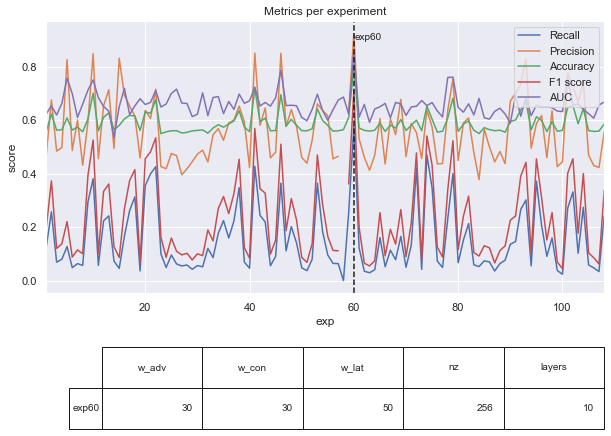

In [31]:
fig = plt.figure(figsize=(10, 5))
plt.plot(x, RECALL, label="Recall")
plt.plot(x, PRECISION, label='Precision')
plt.plot(x, ACCURACY, label='Accuracy')
plt.plot(x, F1_SCORE, label='F1 score')
plt.plot(x, AUC_all, label='AUC')
for i in max_exp:
    plt.axvline(i, linestyle='--', color='k')
    plt.text(i + 0.2, 0.9 , "exp{}".format(i))
plt.ylabel('score')
plt.xlabel("exp")
plt.xlim([min(x), max(x)])
plt.title("Metrics per experiment")
plt.legend(loc='upper right')
table(fig.gca(), table_df, loc='bottom', bbox=[0.1,-0.5,0.9,0.3])
plt.savefig(os.path.join(data_dir, "metrics_per_exp.jpg"), dpi=600, bbox_inches='tight')

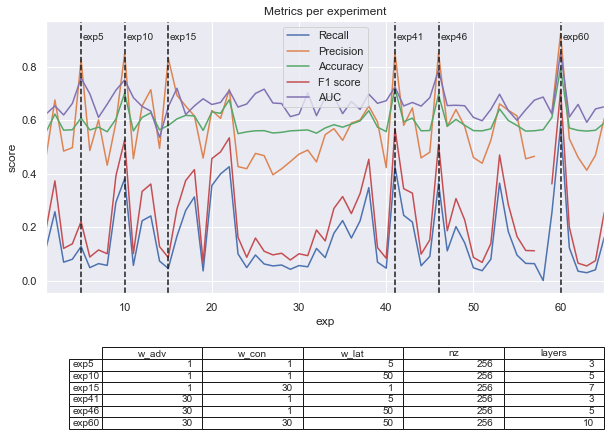

In [35]:
max_exp = [5, 10, 15, 41, 46, 60]
key_list = ['exp'+str(i) for i in max_exp]

fig = plt.figure(figsize=(10, 5))
plt.plot(x[0:65], RECALL[0:65], label="Recall")
plt.plot(x[0:65], PRECISION[0:65], label='Precision')
plt.plot(x[0:65], ACCURACY[0:65], label='Accuracy')
plt.plot(x[0:65], F1_SCORE[0:65], label='F1 score')
plt.plot(x[0:65], AUC_all[0:65], label='AUC')
for i in max_exp:
    plt.axvline(i, linestyle='--', color='k')
    plt.text(i + 0.2, 0.9 , "exp{}".format(i))
plt.ylabel('score')
plt.xlabel("exp")
plt.xlim([min(x[0:65]), max(x[0:65])])
plt.title("Metrics per experiment")
plt.legend(loc='best')
table(fig.gca(), exp_key_df.loc[key_list], loc='bottom', bbox=[0.1,-0.5,0.9,0.3])
plt.savefig(os.path.join(data_dir, "metrics_per_exp_zoom.jpg"), dpi=600, bbox_inches='tight')

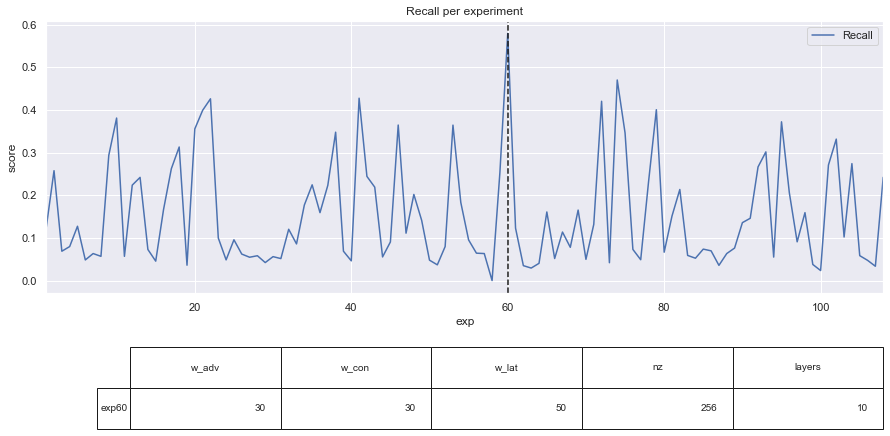

In [36]:
fig = plt.figure(figsize=(15, 5))
plt.plot(x, RECALL, label="Recall")
for i in [rec_max]:
    plt.axvline(i, linestyle='--', color='k')
plt.ylabel('score')
plt.xlabel("exp")
plt.xlim([min(x), max(x)])
plt.title("Recall per experiment")
plt.legend(loc='best')
table(fig.gca(), exp_key_df.loc[['exp'+str(rec_max)]], loc='bottom', bbox=[0.1,-0.5,0.9,0.3])
plt.savefig(os.path.join(data_dir, "recall_per_exp.jpg"), dpi=600, bbox_inches='tight')

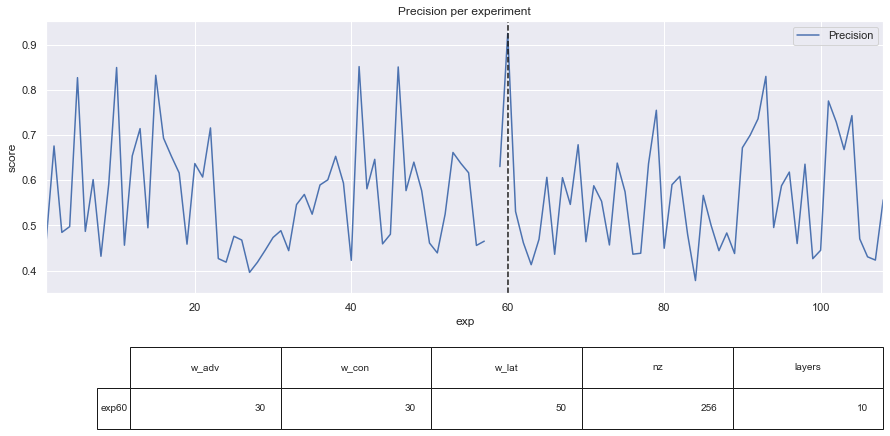

In [37]:
fig = plt.figure(figsize=(15, 5))
plt.plot(x, PRECISION, label="Precision")
for i in [pre_max]:
    plt.axvline(i, linestyle='--', color='k')
plt.ylabel('score')
plt.xlabel("exp")
plt.xlim([min(x), max(x)])
plt.title("Precision per experiment")
plt.legend(loc='best')
table(fig.gca(), exp_key_df.loc[['exp'+str(pre_max)]], loc='bottom', bbox=[0.1,-0.5,0.9,0.3])
plt.savefig(os.path.join(data_dir, "precision_per_exp.jpg"), dpi=600, bbox_inches='tight')

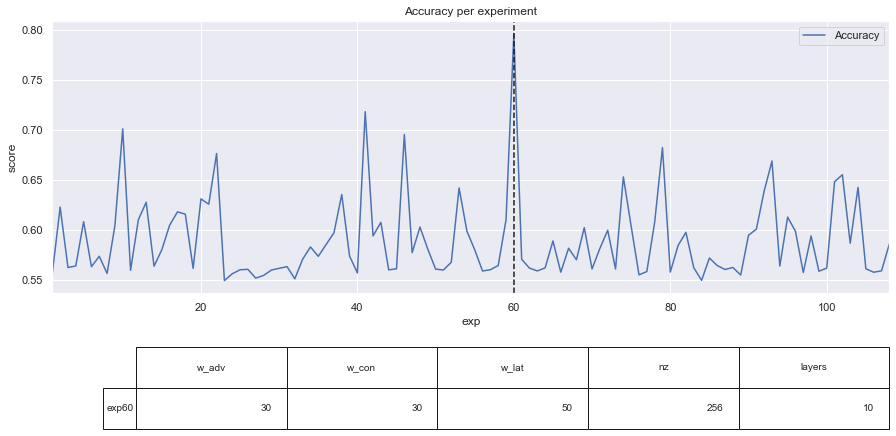

In [38]:
fig = plt.figure(figsize=(15, 5))
plt.plot(x, ACCURACY, label="Accuracy")
for i in [acc_max]:
    plt.axvline(i, linestyle='--', color='k')
plt.ylabel('score')
plt.xlabel("exp")
plt.xlim([min(x), max(x)])
plt.title("Accuracy per experiment")
plt.legend(loc='best')
table(fig.gca(), exp_key_df.loc[['exp'+str(acc_max)]], loc='bottom', bbox=[0.1,-0.5,0.9,0.3])
plt.savefig(os.path.join(data_dir, "accuracy_per_exp.jpg"), dpi=600, bbox_inches='tight')

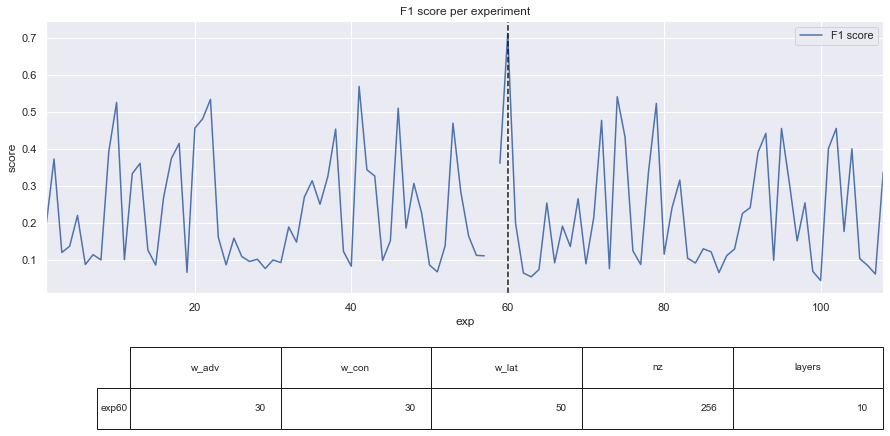

In [39]:
fig = plt.figure(figsize=(15, 5))
plt.plot(x, F1_SCORE, label="F1 score")
for i in [F1_max]:
    plt.axvline(i, linestyle='--', color='k')
plt.ylabel('score')
plt.xlabel("exp")
plt.xlim([min(x), max(x)])
plt.title("F1 score per experiment")
plt.legend(loc='best')
table(fig.gca(), exp_key_df.loc[['exp'+str(F1_max)]], loc='bottom', bbox=[0.1,-0.5,0.9,0.3])
plt.savefig(os.path.join(data_dir, "F1_per_exp.jpg"), dpi=600, bbox_inches='tight')

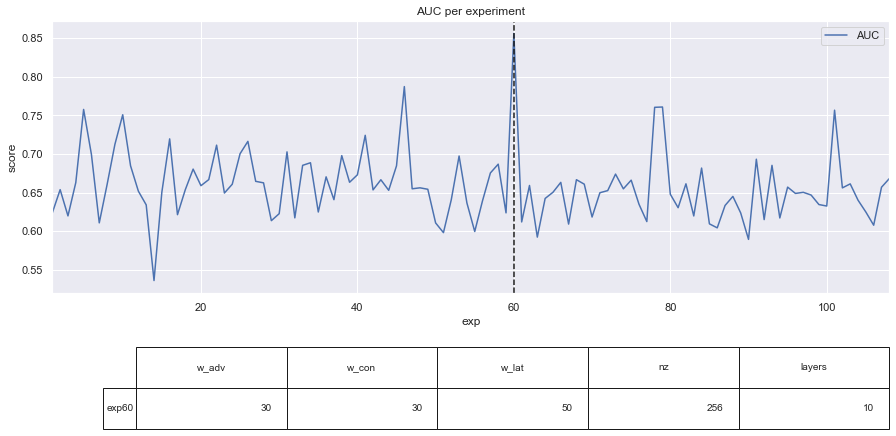

In [40]:
fig = plt.figure(figsize=(15, 5))
plt.plot(x, AUC_all, label="AUC")
for i in [auc_max]:
    plt.axvline(i, linestyle='--', color='k')
plt.ylabel('score')
plt.xlabel("exp")
plt.xlim([min(x), max(x)])
plt.title("AUC per experiment")
plt.legend(loc='best')
table(fig.gca(), exp_key_df.loc[['exp'+str(rec_max)]], loc='bottom', bbox=[0.1,-0.5,0.9,0.3])
plt.savefig(os.path.join(data_dir, "AUC_per_exp.jpg"), dpi=600, bbox_inches='tight')

### Inspect a single experiment

In [16]:
exp = 'exp60'
exp_dir = os.path.join(data_dir, exp)
report_dir = os.path.join(exp_dir, "report")
train_dir = os.path.join(os.path.join(data_dir, exp), "train")
test_dir = os.path.join(os.path.join(data_dir, exp), "test")
anom_dir = os.path.join(train_dir, "anom")
anom_dir2 = os.path.join(test_dir, "anom")
error_dir = os.path.join(train_dir, "errors")

# open eror pkl file
errors = []
with (open(os.path.join(error_dir, "errors.pkl"), "rb")) as openfile:
    while True:
        try:
            errors.append(pickle.load(openfile))
        except EOFError:
            break

# store error information
epoch = []
steps = []
err_d = []
err_g = []
err_g_adv = []
err_g_con = []
err_g_lat = []

for i in errors:
    epoch.append(i['epoch'])
    steps.append(i['steps'])
    err_d.append(i['errors']['err_d'])
    err_g.append(i['errors']['err_g'])
    err_g_adv.append(i['errors']['err_g_adv'])
    err_g_con.append(i['errors']['err_g_con'])
    err_g_lat.append(i['errors']['err_g_lat'])

# count number of unique epochs
unique_epoch = list(set(epoch))

# open scores.pkl file: specify anom_dir or anom_dir2
scores = []
# with (open(os.path.join(anom_dir, "scores.pkl"), "rb")) as openfile:
#     while True:
#         try:
#             scores.append(pickle.load(openfile))
#         except EOFError:
#             break
            
with (open(os.path.join(anom_dir, "scores.pkl"), "rb")) as openfile:
    while True:
        try:
            scores.append(pickle.load(openfile))
        except EOFError:
            break

# Extract anomaly score values and calculate AUC score
auc_epoch = []
epoch = []
e_len = len(scores[0]['gt_labels'])
all_an_scores = np.empty((len(list(unique_epoch)), e_len))
all_gt_labels = np.empty((len(list(unique_epoch)), e_len))
all_sample_ids = np.empty((len(list(unique_epoch))*2, e_len))

for i, s in enumerate(scores):
    gt_labels = s['gt_labels']
    an_scores = s['an_scores']
    ids = s['ids']
    all_gt_labels[i] = gt_labels
    all_an_scores[i] = an_scores
    index = i * 2
    all_sample_ids[index: index+2] = ids.T
    fpr, tpr, _ = roc_curve(gt_labels, an_scores)
    epoch.append(i)
    auc_epoch.append(auc(fpr, tpr))

# AUC over time
AUC(epoch, auc_epoch)

# find epoch with highest AUC value
max_value = max(auc_epoch)
highest_epoch = unique_epoch[auc_epoch.index(max_value)]

# find index of epoch with highest AUC value
highest_epoch_idx = auc_epoch.index(max_value)

#     print(highest_epoch, highest_epoch_idx)

#### Anomaly scores distributions

# Extract anomaly scores for highest AUC epoch
an_scores = all_an_scores[highest_epoch_idx]
gt_scores = all_gt_labels[highest_epoch_idx]
index_anomalies = np.where(gt_scores == 1)[0]
index_normals = np.where(gt_scores == 0)[0]

an_scores_normal = all_an_scores[highest_epoch_idx, index_normals]
an_scores_abnormal = all_an_scores[highest_epoch_idx, index_anomalies]

an_scores_copy = an_scores

# check distribution of scores
normal_message = normaltest(an_scores_normal)
anom_message = normaltest(an_scores_abnormal)

# find threshold
result = get_threshold(an_scores_normal, an_scores_abnormal)
threshold = np.max(result)

C:\Users\TilonSM\AppData\Roaming\Python\Python37\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


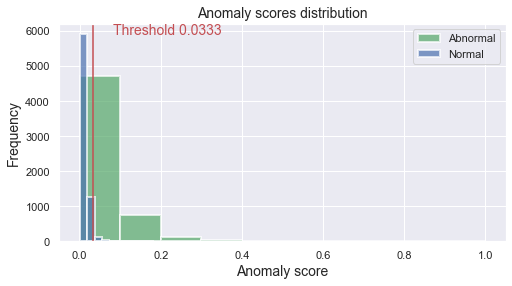

In [29]:
# plot anomaly scores distributions
#     anomaly_dist(an_scores_normal, an_scores_abnormal, normal_message, anom_message, highest_epoch_idx)
fig, ax = plt.subplots(figsize=(8,4))
plt.hist(an_scores_abnormal, color='g', alpha=0.7, linewidth=2, label = 'Abnormal')
plt.hist(an_scores_normal, color='b', alpha=0.7, linewidth=2, label='Normal')
plt.title('Anomaly scores distribution'.format(highest_epoch_idx), fontsize=14)
plt.grid(True)
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Anomaly score', fontsize=14)
plt.axvline(threshold, color='r')
ymin, ymax = ax.get_ylim()
plt.text(threshold + 0.05, ymax-((ymax-ymin)/100 * 5), "Threshold {}".format(round(threshold, 4)), color='r', fontsize=14)
plt.legend()
plt.savefig(os.path.join(report_dir, "anomaly_scores_distribution2.jpg"), dpi=600)

In [22]:
report_dir

'C:\\Users\\TilonSM\\Documents\\RoadSurfaceDamageUAV\\src\\models\\skipganomaly\\output\\gan-run_GAP2\\exp60\\report'

### Inspect exp 60 full

In [13]:
data_dir = r"C:\Users\TilonSM\Documents\RoadSurfaceDamageUAV\src\models\skipganomaly\output"
exp = "gan-GAP2_exp60_full"

exp_dir = os.path.join(data_dir, exp)
report_dir = os.path.join(exp_dir, "report")

if not os.path.exists(report_dir):
    os.mkdir(report_dir)

# specify training and training/eror dir
train_dir = os.path.join(exp_dir, "train")
error_dir = os.path.join(train_dir, "errors")

# open eror pkl file
errors = []
with (open(os.path.join(error_dir, "errors.pkl"), "rb")) as openfile:
    while True:
        try:
            errors.append(pickle.load(openfile))
        except EOFError:
            break

# store error information
epoch = []
steps = []
err_d = []
err_g = []
err_g_adv = []
err_g_con = []
err_g_lat = []

for i in errors:
    epoch.append(i['epoch'])
    steps.append(i['steps'])
    err_d.append(i['errors']['err_d'])
    err_g.append(i['errors']['err_g'])
    err_g_adv.append(i['errors']['err_g_adv'])
    err_g_con.append(i['errors']['err_g_con'])
    err_g_lat.append(i['errors']['err_g_lat'])

# count number of unique epochs
unique_epoch = list(set(epoch))
# find index of unique epochs
indexes = [(x, epoch.index(x)) for x in unique_epoch]

### 1. Generator and Discriminator error
# create x value list for plotting purposes
x = np.arange(min(steps), (len(err_d)) * 8000, 8000)

D_G_loss(err_d, err_g, x)

### 2. Adversarial, contextual and encoder error

# plot adv, cont and enc error
adv_con_enc_error(err_g_adv, err_g_con, err_g_lat, x)

# Testing

#### Remind ourselves of test set statistics ## CHANGE!

# test statistics
test_norm = r"C:\Users\TilonSM\Documents\RoadSurfaceDamageUAV\data\processed\GAP2\test_norm.npy"
test_anom = r"C:\Users\TilonSM\Documents\RoadSurfaceDamageUAV\data\processed\GAP2\test_anom.npy"
t1 = np.load(test_norm, mmap_mode="r")
t2 = np.load(test_anom, mmap_mode='r')
test_len = len(t1) + len(t2)

#     print("normal samples {}".format(t1))
#     print("abnormal samples {}".format(t2))
#     print("test length is {}".format(test_len))

### 3. Inspect anomaly scores

# specify anomaly dir
train_dir = os.path.join(os.path.join(data_dir, exp), "train")
anom_dir = os.path.join(train_dir, "anom")

# open scores.pkl file
scores = []
with (open(os.path.join(anom_dir, "scores.pkl"), "rb")) as openfile:
    while True:
        try:
            scores.append(pickle.load(openfile))
        except EOFError:
            break

# Extract anomaly score values and calculate AUC score
auc_epoch = []
epoch = []
e_len = len(scores[0]['gt_labels'])
all_an_scores = np.empty((len(list(unique_epoch)), e_len))
all_gt_labels = np.empty((len(list(unique_epoch)), e_len))
all_sample_ids = np.empty((len(list(unique_epoch))*2, e_len))

for i, s in enumerate(scores):
    gt_labels = s['gt_labels']
    an_scores = s['an_scores']
    ids = s['ids']
    all_gt_labels[i] = gt_labels
    all_an_scores[i] = an_scores
    index = i * 2
    all_sample_ids[index: index+2] = ids.T
    fpr, tpr, _ = roc_curve(gt_labels, an_scores)
    epoch.append(i)
    auc_epoch.append(auc(fpr, tpr))

# AUC over time
AUC(epoch, auc_epoch)

# find epoch with highest AUC value
max_value = max(auc_epoch)
highest_epoch = unique_epoch[auc_epoch.index(max_value)]

print("AUC is {}".format(max_value))

# find index of epoch with highest AUC value
highest_epoch_idx = auc_epoch.index(max_value)

#     print(highest_epoch, highest_epoch_idx)

#### Anomaly scores distributions

# Extract anomaly scores for highest AUC epoch
an_scores = all_an_scores[highest_epoch_idx]
gt_scores = all_gt_labels[highest_epoch_idx]
index_anomalies = np.where(gt_scores == 1)[0]
index_normals = np.where(gt_scores == 0)[0]

an_scores_normal = all_an_scores[highest_epoch_idx, index_normals]
an_scores_abnormal = all_an_scores[highest_epoch_idx, index_anomalies]

an_scores_copy = an_scores
#     print("Minimum anomaly score: {}".format(min(an_scores)))
#     print("Maximum anomaly score: {}".format(max(an_scores)))
#     print("Top 10 anomaly scores: \n {}".format(an_scores[an_scores_copy.argsort()[-10:][::-1]]))

# check distribution of scores
normal_message = normaltest(an_scores_normal)
anom_message = normaltest(an_scores_abnormal)

# find threshold
result = get_threshold(an_scores_normal, an_scores_abnormal)
threshold = np.max(result)

# plot anomaly scores distributions
anomaly_dist(an_scores_normal, an_scores_abnormal, normal_message, anom_message, highest_epoch_idx)

# plot ROC curve
ROC_curve(gt_scores, an_scores, highest_epoch_idx)

# create binary scores using threshold
#     print("nr of anomalies using threshold {}: {}".format(threshold, len(np.where(an_scores > threshold)[0])))

bi_scores = np.copy(an_scores)
bi_scores[bi_scores >= threshold] = 1
bi_scores[bi_scores < threshold] = 0
#     print(len(np.where(bi_scores == 1.)[0]))
#     print(np.unique(bi_scores))

# Average precision --> influenced by the threshold value (EER or Youden index? Threshold that maximizes recall)
ap = average_precision_score(gt_scores, bi_scores)

#     print("Average precision is {} with threshold {}".format(ap, threshold))

# precision recall curve
pr_curve(gt_scores, bi_scores)

# Plot confusion matrixes
class_names = ['nom', 'anom']
recall, precision, accuracy, F1 = plot_confusion_matrix(gt_scores, bi_scores, threshold, classes=class_names, dummy=False)

print("Recall is {}".format(recall))
print("Precision is {}".format(precision))
print("Accuracy is {}".format(accuracy))
print("F1 is {}".format(F1))

# DUMMY CLASSIFIER error metric
dummy_bi_scores = np.ones((an_scores.shape))

plot_confusion_matrix(gt_scores, dummy_bi_scores, threshold, classes=class_names, dummy=True)

AUC is 0.5848603231276466


C:\Users\TilonSM\AppData\Roaming\Python\Python37\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Recall is 0.03155575143234905
Precision is 0.4211467425828765
Accuracy is 0.5595986955687704
F1 is 0.058712298258475154


(1.0, 0.4352580088240936, 0.4352580088240936, 0.6065223202352312)